### Proyecto final - Karime Jiménez Romero

Utilizando dataset *Clasificación Brain Tumor*

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scikeras.utils.random_state import tensorflow_random_state
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from itertools import cycle
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from sklearn.utils import shuffle
from PIL import Image
from tensorflow.python.keras.callbacks import EarlyStopping

In [2]:
testing = r"C:\Users\karim\OneDrive\Documentos\Neurociencias-2025-2\S06_proyecto\dataset\Testing"
training = r"C:\Users\karim\OneDrive\Documentos\Neurociencias-2025-2\S06_proyecto\dataset\Training"

In [3]:
main_fold = r"C:\Users\karim\OneDrive\Documentos\Neurociencias-2025-2\S06_proyecto\dataset\Training"
subfolders = [f for f in os.listdir(main_fold) if os.path.isdir(os.path.join(main_fold,f))]
#agrupar las imagenes
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_fold,folder)
    images = [os.path.join(path, img) for img in os.listdir(path)
                if img.endswith(".jpg")]
    random.shuffle(images)
    folder_images[folder] = images

selected_images = []
folder_cycle = cycle(subfolders)
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:
        selected_images.append(folder_images[folder].pop)

In [4]:
main_fold = r"C:\Users\karim\OneDrive\Documentos\Neurociencias-2025-2\S06_proyecto\dataset\Testing"
subfolders = [f for f in os.listdir(main_fold) if os.path.isdir(os.path.join(main_fold,f))]
#agrupar las imagenes
folder_images = {}
for folder in subfolders:
    path = os.path.join(main_fold,folder)
    images = [os.path.join(path, img) for img in os.listdir(path)
                if img.endswith(".jpg")]
    random.shuffle(images)
    folder_images[folder] = images

selected_images = []
folder_cycle = cycle(subfolders)
while len(selected_images) < 16:
    folder = next(folder_cycle)
    if folder_images[folder]:
        selected_images.append(folder_images[folder].pop)

1. Análisis de dataset

In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [6]:
def cnn_preprocess(x):
    return x / 255.0

In [7]:
train_path = ImageDataGenerator(preprocessing_function=cnn_preprocess)
train_generator = train_path.flow_from_directory(
        training,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

train_generator.class_indices

Found 5712 images belonging to 4 classes.


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

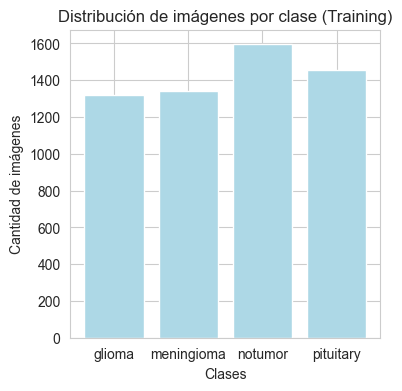

In [8]:
class_names = os.listdir(training)
class_counts = {cls: len(os.listdir(os.path.join(training, cls))) for cls in class_names}
plt.figure(figsize=(4,4))
plt.bar(class_counts.keys(), class_counts.values(), color="lightblue")
plt.title("Distribución de imágenes por clase (Training)")
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.show()

In [9]:
test_path = ImageDataGenerator(preprocessing_function=cnn_preprocess)
test_generator = test_path.flow_from_directory(
        testing,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
test_generator.class_indices

Found 1311 images belonging to 4 classes.


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

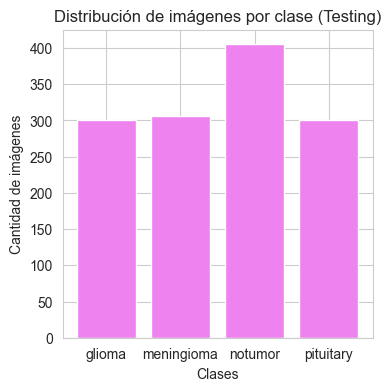

In [10]:
class_names = os.listdir(testing)

class_counts = {cls: len(os.listdir(os.path.join(testing, cls))) for cls in class_names}
plt.figure(figsize=(4,4))
plt.bar(class_counts.keys(), class_counts.values(), color="violet")
plt.title("Distribución de imágenes por clase (Testing)")
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.show()

In [11]:
#verificar tamaños y formatos de imágenes
sizes = []
formats = []

for cls in class_names:
    folder = os.path.join(training, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            sizes.append(img.size)
            formats.append(img.format)
        except:
            print(f"Error al abrir {img_path}")

from collections import Counter

print("Tamaños más comunes (Training):", Counter(sizes).most_common(5))
print("Formatos de imagen:", Counter(formats))

Tamaños más comunes (Training): [((512, 512), 3955), ((225, 225), 268), ((630, 630), 77), ((236, 236), 53), ((201, 251), 43)]
Formatos de imagen: Counter({'JPEG': 5707, 'PNG': 5})


In [12]:
sizes = []
formats = []

for cls in class_names:
    folder = os.path.join(testing, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path)
            sizes.append(img.size)
            formats.append(img.format)
        except:
            print(f"Error al abrir {img_path}")

from collections import Counter

print("Tamaños más comunes (Testing):", Counter(sizes).most_common(5))
print("Formatos de imagen:", Counter(formats))

Tamaños más comunes (Testing): [((512, 512), 787), ((225, 225), 64), ((236, 236), 28), ((227, 222), 17), ((201, 251), 15)]
Formatos de imagen: Counter({'JPEG': 1311})


2. Identificación del tipo de problema

Como se observa, cada carpeta represnta una clase distinta y se clasifican las imágenes en una de esas clases, por lo tanto estamos de hablando de un problema de **clasificación.**


3. Creación de propuestas de modelos

*Modelo CNN*

In [13]:
cnn_model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.4),

    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),

    Dense(len(class_names), activation="softmax", dtype="float32")
])


In [14]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,200,964 (42.73 MB)

 Trainable params: 11,200,964 (42.73 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
callbacks = EarlyStopping (monitor=("val_loss"), patience=5)

history = cnn_model.fit(
        train_generator,
        epochs = 10,
        validation_data = test_generator,
        callbacks = callbacks
        )

C:\Users\karim\PycharmProjects\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 737s 4s/step - accuracy: 0.6029 - loss: 0.8624 - val_accuracy: 0.8215 - val_loss: 0.4339
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 621s 3s/step - accuracy: 0.8892 - loss: 0.3051 - val_accuracy: 0.8535 - val_loss: 0.3807
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 660s 4s/step - accuracy: 0.9310 - loss: 0.2037 - val_accuracy: 0.9169 - val_loss: 0.2116
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 633s 4s/step - accuracy: 0.9594 - loss: 0.1147 - val_accuracy: 0.9230 - val_loss: 0.2177
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 617s 3s/step - accuracy: 0.9746 - loss: 0.0704 - val_accuracy: 0.9504 - val_loss: 0.1796
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 618s 3s/step - accuracy: 0.9830 - loss: 0.0502 - val_accuracy: 0.9474 - val_loss: 0.1856
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 649s 4s/step - accuracy: 0.9900 - loss: 0.0320 - val_accuracy: 0.9596 - val_loss: 0.1239
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 646s 4s/step - accuracy: 0.9924 - loss: 0.0230 - val_accu

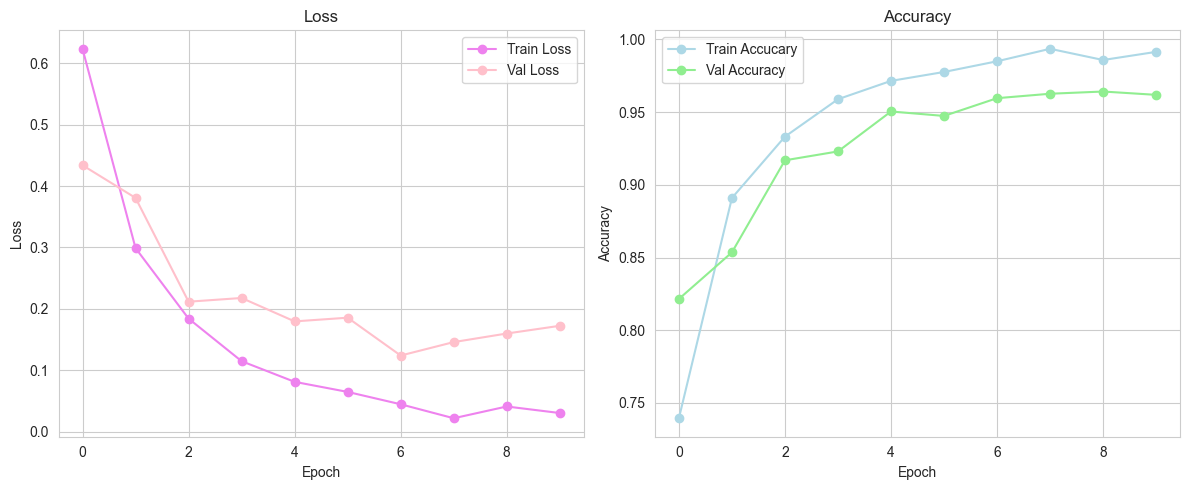

In [17]:
plt.figure(figsize=(12, 5))
#loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss", color="violet", marker= "o")
plt.plot(history.history["val_loss"], label="Val Loss", color="pink", marker= "o")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accucary", color="lightblue", marker= "o")
plt.plot(history.history["val_accuracy"], label="Val Accuracy", color="lightgreen", marker= "o")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

 4. Evaluación de resultados

In [27]:
def evaluate_model(cnn_model, test_generator):
    test_generator.reset()
    preds = cnn_model.predict(test_generator)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_generator.classes

    print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

print("Evaluación CNN personalizada:")
evaluate_model(cnn_model, test_generator)

Evaluación CNN personalizada:
41/41 ━━━━━━━━━━━━━━━━━━━━ 45s 936ms/step
              precision    recall  f1-score   support

      glioma       0.21      0.19      0.20       300
  meningioma       0.24      0.26      0.25       306
     notumor       0.33      0.33      0.33       405
   pituitary       0.25      0.25      0.25       300

    accuracy                           0.26      1311
   macro avg       0.26      0.26      0.26      1311
weighted avg       0.26      0.26      0.26      1311



41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 689ms/step


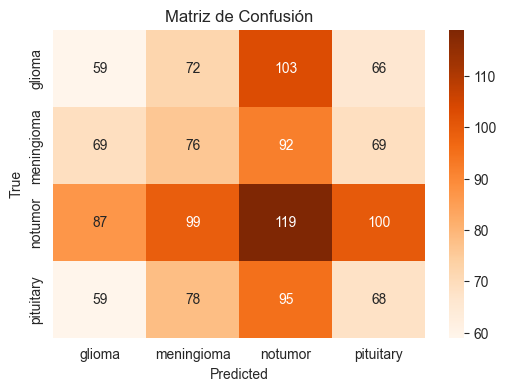

In [29]:
preds = cnn_model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.show()

5. Análisis de resultados

Se fueron realizando varios ajustes a la CNN para poder obtener la accuracy final. Los cambios que fui realizando constaban en cambiando las capas, al final agregue 3 bloques con filtros de 64 y 128 neuronas,  esto para una extracción progresiva de características. Ajuste el dropout a 0.4 para prevenir un sobreajuste.


Este modelo demostró ser mejor al irlo ajustando para la clasificación de imágenes en este trabajo. Su estructura utilizando tres bloques y el valor de Dropout, logró un buen equilibrio entre la extracción de características visuales y la prevención del sobreajuste.